# ML Regression to estimate BF of a individual

Quantifying health with a numerical value is an effective way to demonstrate an individual's well-being and to track progress over time during a training regimen or diet. For many years, the Body Mass Index (BMI) has been widely used for this purpose. However, BMI is increasingly falling out of favor for individual health assessment as it fails to distinguish between different components of body composition, such as fat, muscle, and bone mass. Consequently, BMI can misrepresent an individual's health status by treating all mass equally, whether in deficiency or excess.

In recent years, Body Fat (BF) percentage has become a more common metric as it specifically measures the proportion of fat relative to the rest of the body. Unlike BMI, which is calculated simply by dividing weight by height squared, determining body fat percentage is significantly more complex. One method involves determining an individual's body density, which requires submerging the person in water to measure the displacement and thereby calculate body volume. The individual's weight is then measured, and their density is calculated. This density is used in Siri's formula to estimate body fat percentage.

Given the complexity of accurately calculating BF, developing an alternative method would be highly beneficial. This notebook aims to address this challenge by using a machine learning model to predict body fat percentage. The dataset used for this analysis is available on [Kaggle](https://www.kaggle.com/datasets/fedesoriano/body-fat-prediction-dataset)

## Data
First we import the librarys and the data

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress
from sklearn.model_selection import GridSearchCV, train_test_split
import joblib

In [53]:
data = pd.read_csv('bodyfat.csv')
data.describe()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,1.055574,19.150794,44.884921,178.924405,70.148810,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,0.019031,8.368740,12.602040,29.389160,3.662856,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.995000,0.000000,22.000000,118.500000,29.500000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,1.041400,12.475000,35.750000,159.000000,68.250000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,1.054900,19.200000,43.000000,176.500000,70.000000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,1.070400,25.300000,54.000000,197.000000,72.250000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,1.108900,47.500000,81.000000,363.150000,77.750000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


## Treating the data

Now we need to clean the data and remove the variables that are not important to make the prediction. To make the decion on what to remove we take a loo between the correlation of BF and the other variables:

Determination coefficient of BodyFat and Weight: 0.37505091009386476
Determination coefficient of BodyFat and Chest: 0.4936753406273299
Determination coefficient of BodyFat and Abdomen: 0.6616720819241183
Determination coefficient of BodyFat and Hip: 0.39087618725367446
Determination coefficient of BodyFat and Thigh: 0.31316058986451645
Determination coefficient of BodyFat and Knee: 0.2587403293197324


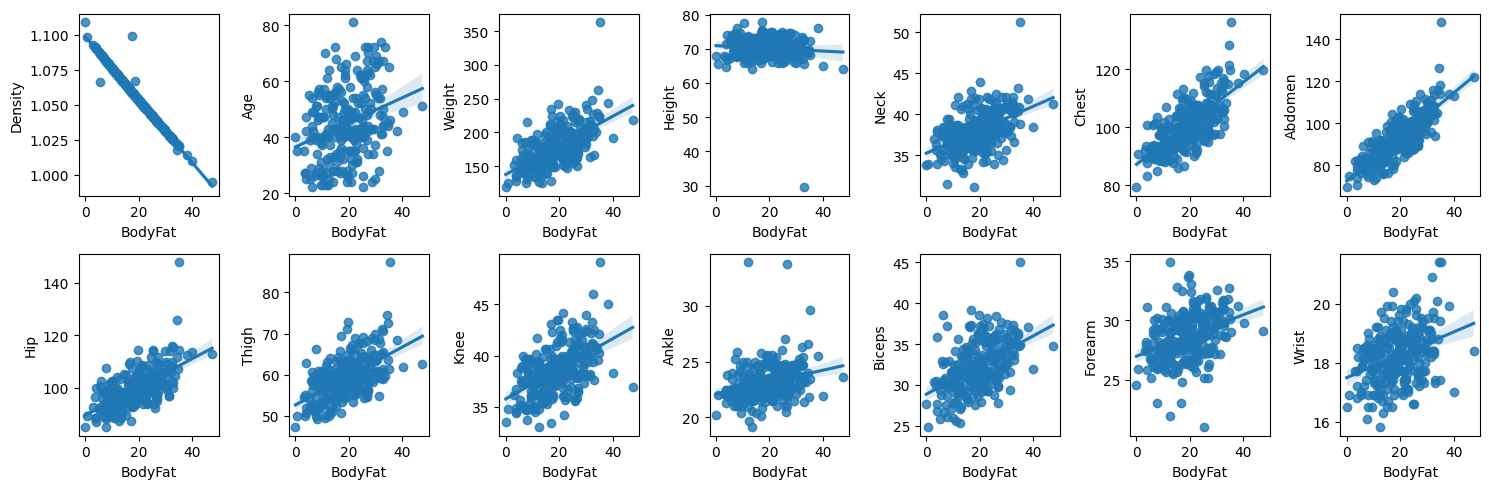

In [54]:
# prompt: make various regplot with x being the bodyfat and y being all other values, print the r values for all regressions
fig, ax = plt.subplots(2, 7, figsize=(15, 5))
ax = ax.flatten()
for i, column in enumerate(data.drop(columns='BodyFat').columns):
  sns.regplot(x=data['BodyFat'], y=data[column], ax = ax[i])
  if (data['BodyFat'].corr(data[column])) > 0.5:
    print(f"Determination coefficient of BodyFat and {column}: {(data['BodyFat'].corr(data[column]))**2}")
plt.tight_layout()
plt.show()

Although the bodyfat in this dataset is calculated by mesuring the desity as cited above there are some outliers as visible in the first plot. To adress this we make a regression and remove the dots that fall way out of the regression prediction:

a: -434, b: 478, r: -0.99
5 points were removed 
a: -446, b: 490, r: -1.00


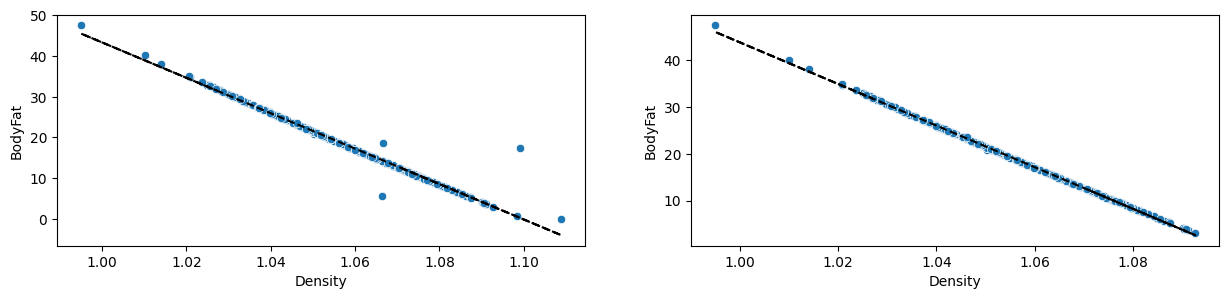

In [72]:

def plot_density_vs_bodyfat_regression(df, ax):
  '''
  Make a linear regression between the density and the bodyfat and return de regression values for avaliation of the outliers
  '''
  slope, intercept, r_value, p_value, std_err = linregress(df['Density'], df['BodyFat'])
  print(f'a: {round(slope)}, b: {round(intercept)}, r: {r_value:.2f}')

  sns.scatterplot(df, x='Density', y='BodyFat', ax=ax)
  ax.plot(df['Density'], slope * df['Density'] + intercept, 'k', ls = '--')

  return slope, intercept, r_value, p_value, std_err

# seting the figure
fig, ax = plt.subplots(1, 2, figsize=(15, 3))

# Making the first plot and regression
slope, intercept, r_value, p_value, std_err = plot_density_vs_bodyfat_regression(data, ax[0])

k=0.05 # Porcentage value to define how acceptable de deviation of a point is.
is_upper_lower_bound = data.BodyFat > (1-k) * (slope * data['Density'] + intercept)
is_lower_upper_bound = data.BodyFat < (1+k) * (slope * data['Density'] + intercept)

#filtering the data
_data  = data[(is_upper_lower_bound) & (is_lower_upper_bound)]
print(f'{len(data)-len(_data)} points were removed ')

plot_density_vs_bodyfat_regression(_data, ax[1])

#setting the filtered dataframe as the the main dataframe
data=_data

Now we remove the outliaers of the chosen parameters

Determination coefficient of BodyFat and Weight: 0.34834338142844945
Determination coefficient of BodyFat and Chest: 0.45703563243716133
Determination coefficient of BodyFat and Abdomen: 0.6536056816649298
Determination coefficient of BodyFat and Hip: 0.366412303883742
Determination coefficient of BodyFat and Thigh: 0.26985360485196214
Determination coefficient of BodyFat and Knee: 0.25629827986311493


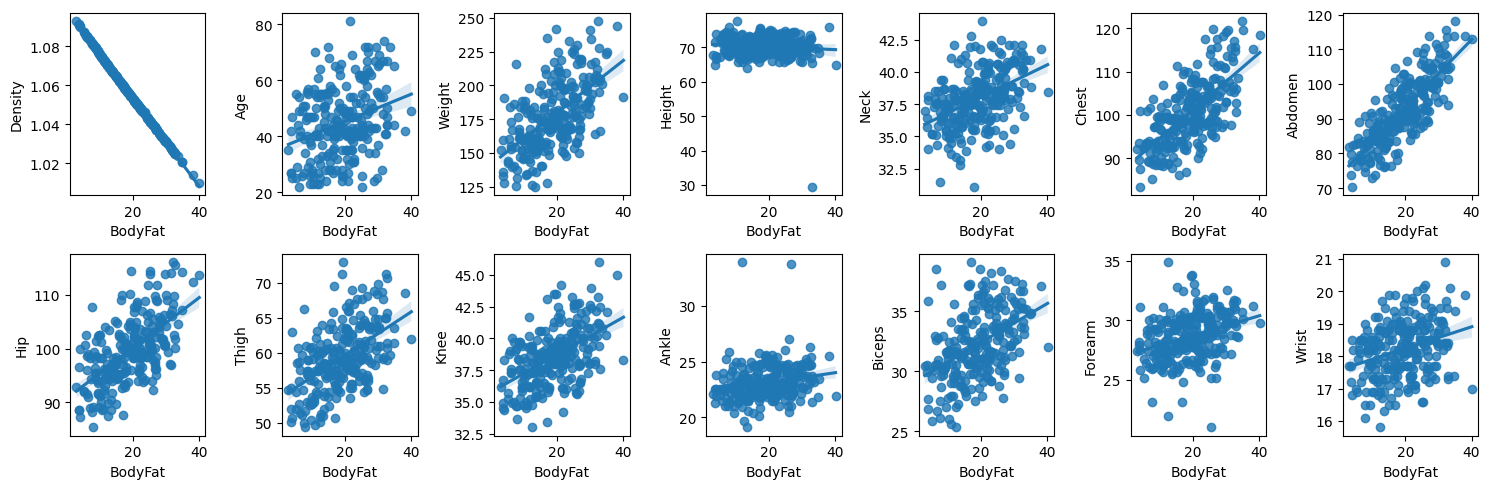

In [73]:
# chosen parameters
params = ['Weight', 'Chest', 'Abdomen', 'Hip', 'Thigh']

_data = data.copy()
for param in params:
  # Calculating the parameters mean and std
  param_std = np.std(_data[param])
  param_mean = np.mean(_data[param])

  # filtering the parameters within 3 std of the mean
  _data = _data[(_data[param]>param_mean-3*param_std) & (_data[param]<param_mean+3*param_std)]

# Remaking the plot to make visible that the outlies are gone
# Could have done a boxplot but i like to emphasize the correlation between the parameters and the bodyfat
fig, ax = plt.subplots(2, 7, figsize=(15, 5))
ax = ax.flatten()
for i, column in enumerate(_data.drop(columns='BodyFat').columns):
  sns.regplot(x=_data['BodyFat'], y=_data[column], ax = ax[i])
  if (_data['BodyFat'].corr(_data[column])) > 0.5:
    print(f"Determination coefficient of BodyFat and {column}: {(_data['BodyFat'].corr(_data[column]))**2}")
plt.tight_layout()
plt.show()
data=_data

In [74]:
# Splitting the dataset into parameters and result
X = data[params]
y = data['BodyFat']

# Splitting the dataset into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Models

Now I'd like to showcase some different models and for it we create a template to standardize the output

In [75]:
def train_model(X_train, y_train, X_test, y_test, model, param_grid = None):
  '''
  Train and evaluate the model
  '''
  # For some models it's interesting to look for different parameters, and for
  # it we're using the grid search
  if param_grid is not None:
    # Set up the grid search with cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=10, scoring='neg_mean_squared_error')

    grid_search.fit(X_train, y_train)

    # Print the best parameters found by the grid search
    print("Best parameters found: ", grid_search.best_params_)

    model = grid_search.best_estimator_

  # In case we're not using the grid search
  else:
    model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  # Evaluate the model
  print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
  print(f"R-squared: {r2_score(y_test, y_pred)}")

  return y_pred, model

def plot_testXpres(y_test, y_pred, title):
  plt.figure(figsize=(10, 5))

  # PLooting the ideal prediction line
  x = np.linspace(min(y_test), max(y_test), 100)
  y = x
  plt.plot(x, y, ls='--', c='k', label = 'Ideal prediction')

  # Plotting the results: Actual vs Predicted
  sns.regplot(x=y_test, y=y_pred, label='Predictions', scatter_kws={'alpha':0.7})
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title(title)
  plt.legend()
  plt.show()

### Linear Regression

In [76]:
from sklearn import linear_model

Mean Squared Error: 18.17608368952282
R-squared: 0.6876058068424367


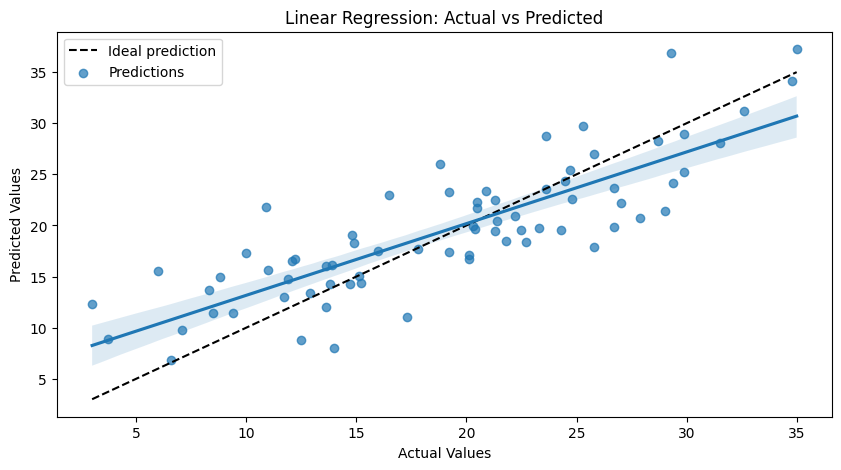

In [77]:
# Create a linear regression object
reg = linear_model.LinearRegression()

y_pred, reg = train_model(X_train, y_train, X_test, y_test, reg)

# Plotting the results: Actual vs Predicted
plot_testXpres(y_test, y_pred, 'Linear Regression: Actual vs Predicted')

### Support Vector Regression

In [78]:
from sklearn.svm import SVR

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters found:  {'C': 100, 'epsilon': 1, 'gamma': 'scale'}
Mean Squared Error: 18.56351210764305
R-squared: 0.6809470353406997


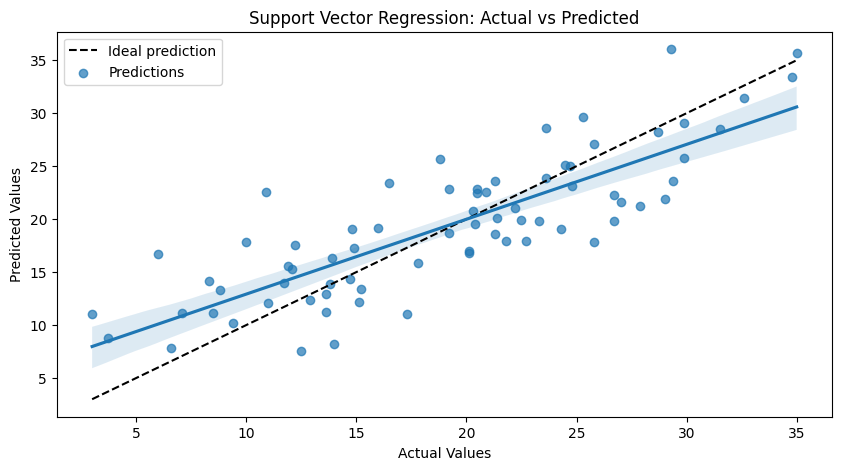

In [79]:
# Define the SVR model
svr = SVR()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'epsilon': [0.1, 0.2, 0.5, 1]
}

y_pred, svr = train_model(X_train, y_train, X_test, y_test, svr, param_grid)

# Plotting the results: Actual vs Predicted
plot_testXpres(y_test, y_pred, 'Support Vector Regression: Actual vs Predicted')

### Neural Network

In [80]:
from sklearn.neural_network import MLPRegressor

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found:  {'hidden_layer_sizes': (100, 100), 'max_iter': 1000}
Mean Squared Error: 17.286425006068605
R-squared: 0.7028964608331807


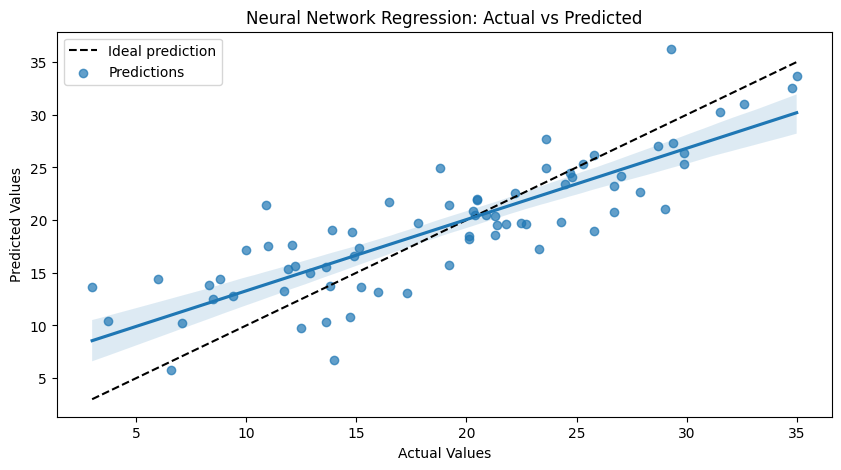

In [81]:
# Initialize the MLPRegressor
mlp = MLPRegressor()

# Define the parameter grid for hyperparameter tuning
param_grid = {
  'hidden_layer_sizes':((10,10), (10, 10, 10), (100, 100)),
  'max_iter':(500, 1000),
}

#Training the model
y_pred, mlp = train_model(X_train, y_train, X_test, y_test, mlp, param_grid)


# Plotting the results: Actual vs Predicted
plot_testXpres(y_test, y_pred, 'Neural Network Regression: Actual vs Predicted')

## Results

As the best predictor was the neural network, we export it to use on a BF calculator

In [82]:
joblib.dump(mlp, 'bodyfatPredictor.pkl')

['bodyfatPredictor.pkl']